# Cell blood type detection

In this project, we are working detect and label names of blood cell types. For example, we have an image of a blood sample, we would like to see how many cell types in the sample and which ones are there.

We will apply the algorithm YOLOv5 on a labeled data set of blood cell types. Pytorch will be the platform library and tool for this learning.

The first step is loading pytorch

In [1]:
import torch

from IPython.display import Image, clear_output  # to display images

torch.cuda.is_available()


False

We need yolov5 library which can be download from github. The easiest way to download is to use git clone method. Make sure that you have git install before you use the following commands. You may need to uncomment to download the library if you have not done so.

In [ ]:
# git clone https://github.com/ultralytics/yolov5
# cd yolov5
# pip install -r requirements.txt

After you downloaded the library, you need to make sure that you have the correct path for your data. In my folder, file data for training is in the yolov5 folder. I modified the data.yaml a little bit so it can point to the correct path. Since I used Windows, some command are different from linux and also the path is messier since you need to use escape for the path. You must use \\ instead of / for path to a subfolder.

In [2]:
cd yolov5

c:\Users\phill\Documents\Studies and Research\Deep learning projects\Object detection and tracking\yolov5


We can take a look at file data.yaml

In [4]:
!type "..\data.yaml"

train: c:\Users\phill\Documents\Studies and Research\Deep learning projects\Object detection and tracking\train\images
val: c:\Users\phill\Documents\Studies and Research\Deep learning projects\Object detection and tracking\valid\images

nc: 3
names: ['Platelets', 'RBC', 'WBC']


We need to obtain the number of classes of you training set from data.yaml generated for your training data.

In [6]:
# define number of classes based on YAML
import yaml
with open("..\data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [7]:
num_classes

'3'

The following command to help us to understand the structure of yolov5m model. I only use yolov5 small version (number of parameters are much smaller than other models) since my computer is not strong enough for bigger model. However, you cannot use the model directly because we are training on our own dataset. Basically, we can keep the same all other parameters, just change the number classes to your training number of classis. See next chunk for writing your custom yolov5m model.

In [9]:
!type "models\yolov5m.yaml"

# !type yolov5s.yaml

# parameters
nc: 80  # number of classes
depth_multiple: 0.67  # model depth multiple
width_multiple: 0.75  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C

We use the magic line command "%%writefile" to write our custom yolov5m.yaml for training. 

In [ ]:
# %%writefile "yolov5\models\custom_yolov5s.yaml"

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [10]:
!type "```models\custom_yolov5s.yaml"



# parameters

nc: {num_classes}  # number of classes

depth_multiple: 0.33  # model depth multiple

width_multiple: 0.50  # layer channel multiple



# anchors

anchors:

  - [10,13, 16,30, 33,23]  # P3/8

  - [30,61, 62,45, 59,119]  # P4/16

  - [116,90, 156,198, 373,326]  # P5/32



# YOLOv5 backbone

backbone:

  # [from, number, module, args]

  [[-1, 1, Focus, [64, 3]],  # 0-P1/2

   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4

   [-1, 3, BottleneckCSP, [128]],

   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8

   [-1, 9, BottleneckCSP, [256]],

   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16

   [-1, 9, BottleneckCSP, [512]],

   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32

   [-1, 1, SPP, [1024, [5, 9, 13]]],

   [-1, 3, BottleneckCSP, [1024, False]],  # 9

  ]



# YOLOv5 head

head:

  [[-1, 1, Conv, [512, 1, 1]],

   [-1, 1, nn.Upsample, [None, 2, 'nearest']],

   [[-1, 6], 1, Concat, [1]],  # cat backbone P4

   [-1, 3, BottleneckCSP, [512, False]],  # 13



   [-1, 1, Conv, [256, 1, 1]],

   [-1

So, we created yolov5 model for traning purpose. Next, I show you how to make a traning on your own data set. The --data is where your data.yaml file locate (recall that data.yaml is the file generated by you/software about the labels of objects). We ask to do traning from scratch, so we request weight learning by using --cfg with the path to your customed yolov5 file you created. And the last step is we give the folder name of the results. All training results are saved to runs/train/ with incrementing run directories, i.e. runs/train/results2, runs/train/results3 etc. every time you train your models.

In [11]:

!python train.py --img 416 --batch 16 --epochs 10 --data "c:\Users\phill\Documents\Studies and Research\Deep learning projects\Object detection and tracking\data.yaml" --cfg .\models\custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

github:  WARNING: code is out of date by 527 commits. Use 'git pull' to update or 'git clone https://github.com/ultralytics/yolov5' to download latest.
Plotting labels... 

autoanchor: Analyzing anchors... anchors/target = 5.83, Best Possible Recall (BPR) = 0.9993
                 all          73         967       0.019       0.374      0.0286     0.00598
                 all          73         967       0.354       0.319      0.0264     0.00587
                 all          73         967      0.0274       0.114      0.0261     0.00576
                 all          73         967      0.0234       0.187      0.0218     0.00395
                 all          73         967      0.0651       0.364      0.0522     0.00888
                 all          73         967      0.0859       0.219       0.063      0.0119
                 all          73         967      0.0654       0.363      0.0773      0.0139
                 all          73         967       0.101       0.382        0.12    

From https://github.com/ultralytics/yolov5
   dad8660..ce7fa81  master     -> origin/master
YOLOv5 v4.0-126-g886f1c0 torch 1.9.1 CPU

Namespace(adam=False, batch_size=16, bucket='', cache_images=True, cfg='.\\models\\custom_yolov5s.yaml', data='c:\\Users\\phill\\Documents\\Studies and Research\\Deep learning projects\\Object detection and tracking\\data.yaml', device='', entity=None, epochs=10, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[416, 416], linear_lr=False, local_rank=-1, log_artifacts=False, log_imgs=16, multi_scale=False, name='yolov5s_results', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs\\train\\yolov5s_results4', single_cls=False, sync_bn=False, total_batch_size=16, weights="''", workers=8, world_size=1)
wandb: Install Weights & Biases for YOLOv5 logging with 'pip install wandb' (recommended)
Start Tensorboard with "tensorboard --logdi

In [ ]:
If you prefer tensorboard to view the training perform, we can use the following commands

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
# %load_ext tensorboard
# %tensorboard --logdir runs

We can see how your model training perform without tensorboard feature as following:

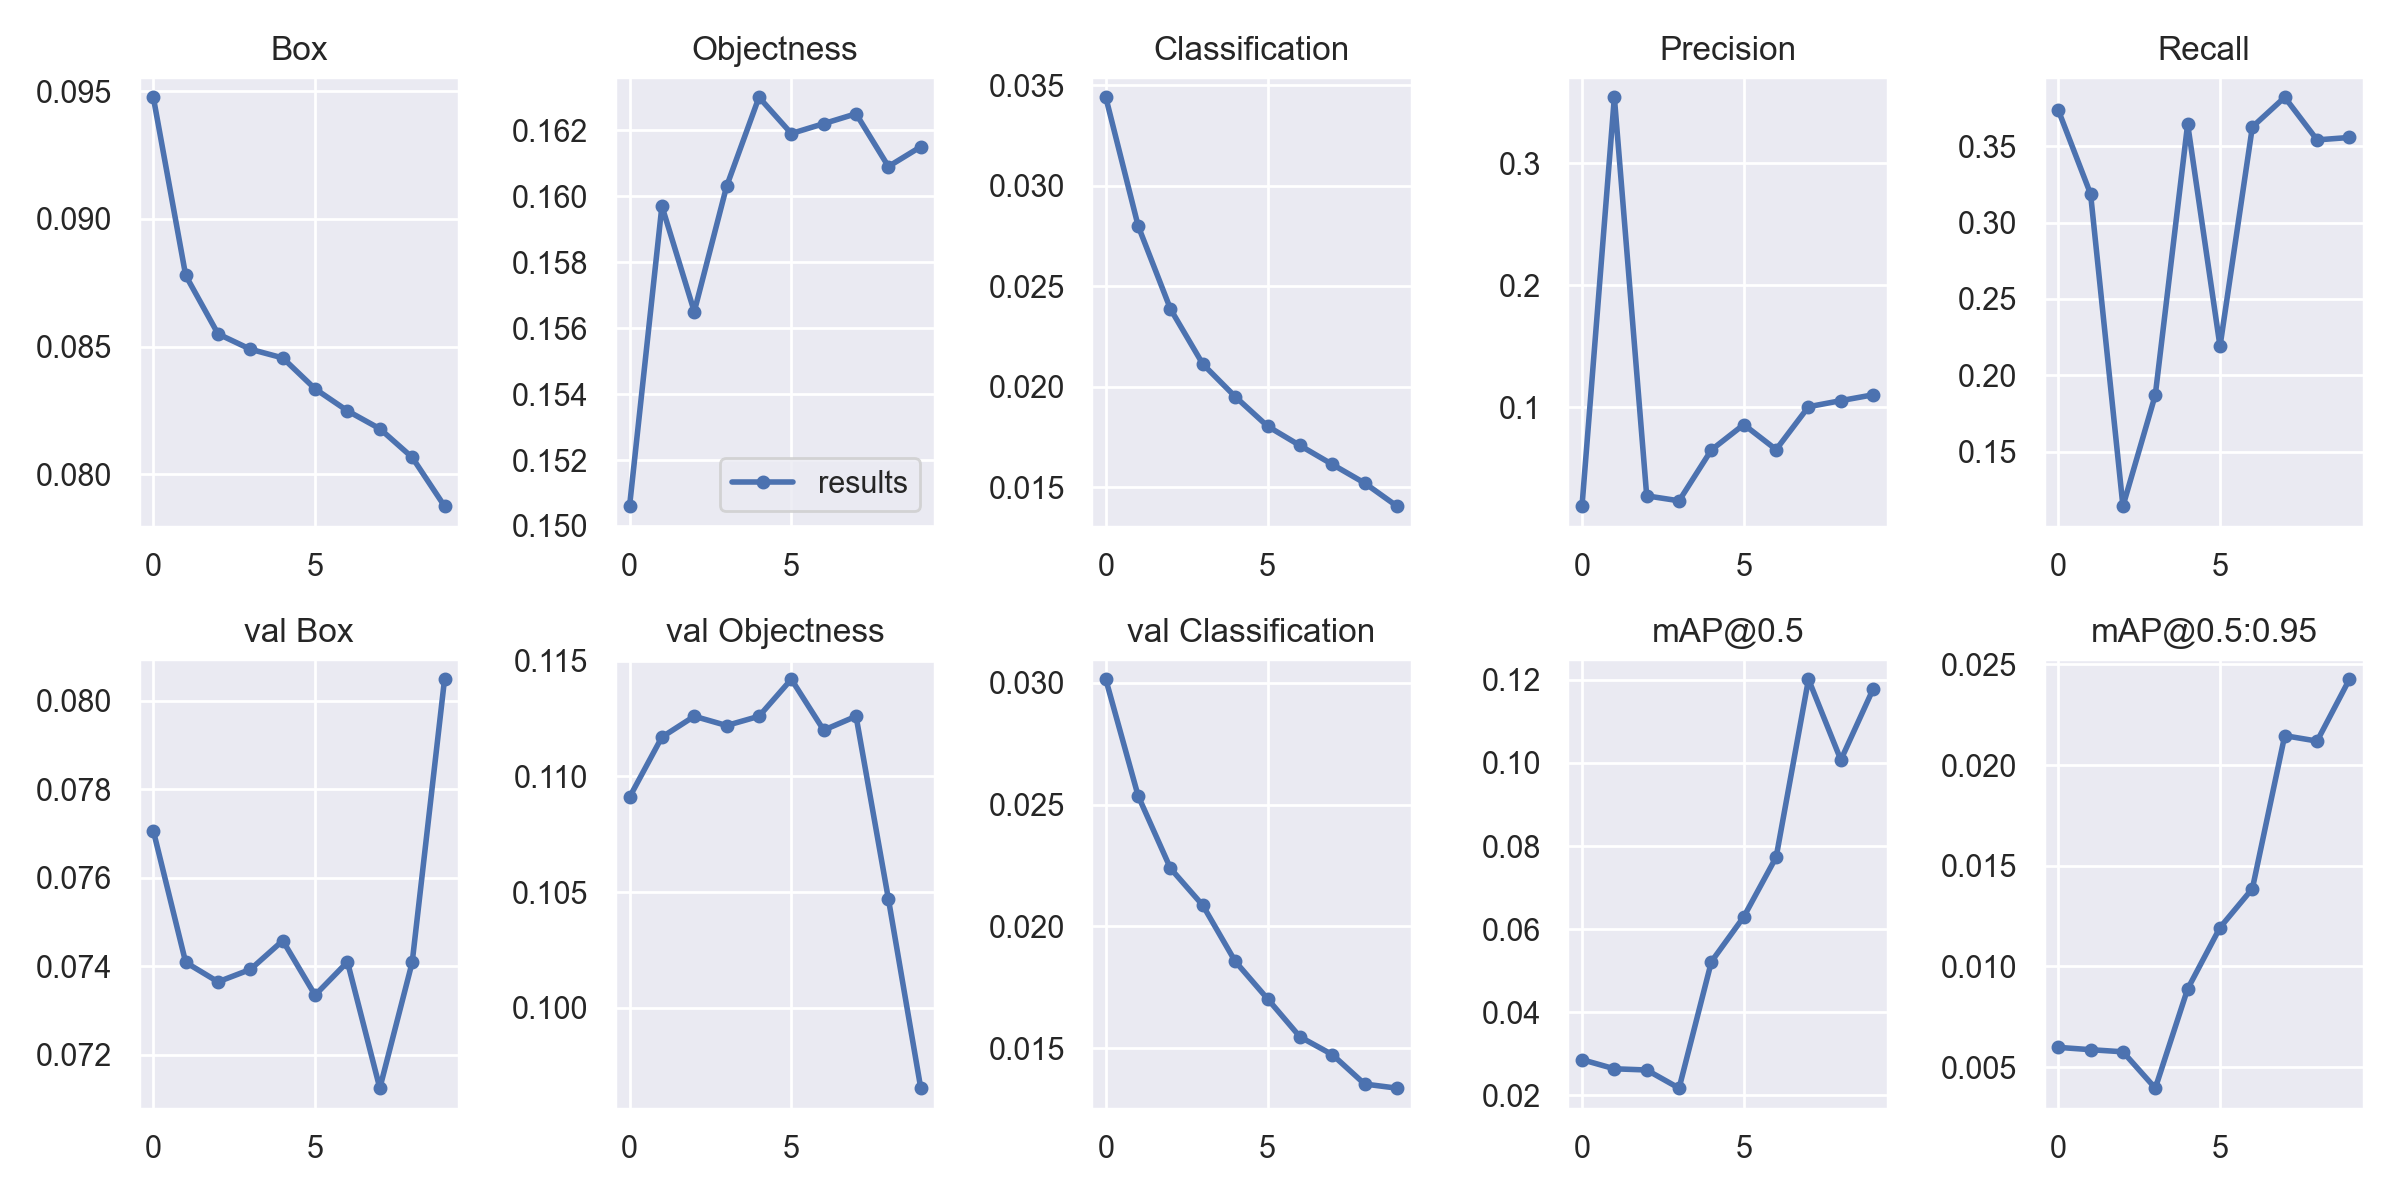

In [18]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='runs\\train/yolov5s_results4\\results.png', width=1000)  # view results.png

GROUND TRUTH TRAINING DATA:


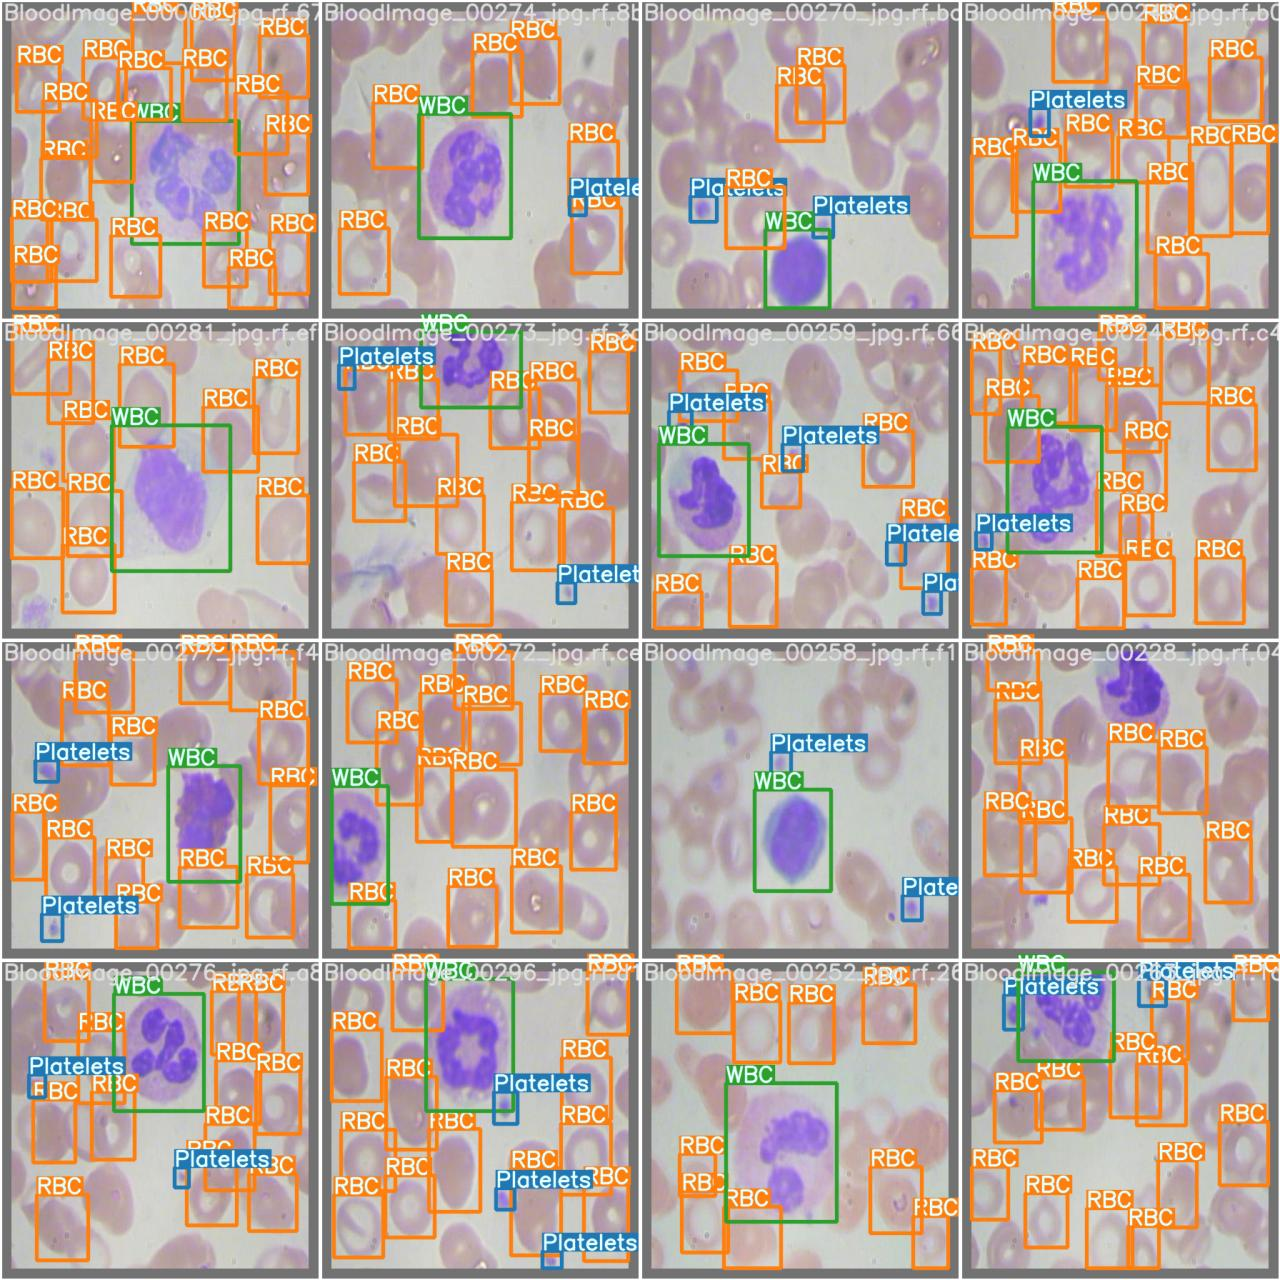

In [17]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename="c:\\Users\\phill\\Documents\\Studies and Research\\Deep learning projects\\Object detection and tracking\\yolov5\\runs\\train\yolov5s_results4\\test_batch0_labels.jpg", width=900)

In [15]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!

!python detect.py --weights "c:\\Users\\phill\\Documents\\Studies and Research\\Deep learning projects\\Object detection and tracking\\yolov5\\runs\\train\\yolov5s_results3\\weights\\best.pt" --img 416 --conf 0.4 --source "c:\\Users\\phill\\Documents\\Studies and Research\\Deep learning projects\\Object detection and tracking\\test\\images"


Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=416, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='c:\\\\Users\\\\phill\\\\Documents\\\\Studies and Research\\\\Deep learning projects\\\\Object detection and tracking\\\\test\\\\images', update=False, view_img=False, weights=['c:\\\\Users\\\\phill\\\\Documents\\\\Studies and Research\\\\Deep learning projects\\\\Object detection and tracking\\\\yolov5\\\\runs\\\\train\\\\yolov5s_results3\\\\weights\\\\best.pt'])
Fusing layers... 
image 1/36 c:\Users\phill\Documents\Studies and Research\Deep learning projects\Object detection and tracking\test\images\BloodImage_00038_jpg.rf.ffa23e4b5b55b523367f332af726eae8.jpg: 416x416 Done. (0.085s)
image 2/36 c:\Users\phill\Documents\Studies and Research\Deep learning projects\Object detection and tracking\test\images\BloodImage_00044_jpg.rf.e7760375eba4bc20c5746367e2311e18.jpg: 416x416 Done. (0.

YOLOv5 v4.0-126-g886f1c0 torch 1.9.1 CPU

Model Summary: 232 layers, 7251912 parameters, 0 gradients, 16.8 GFLOPS


So, how do we make prediction (dectection). We use the detect function provided by yolo. Note that we need to give the path to the weight that we got during training (which is in the yolov5s_results) folder, --cof is the lower cut of the confident probability you want the model to show output. If you set too high, you may not get any results. --source is where the file/files/folder/url ... you would like to make predictions.

In [25]:
!python detect.py --weights "c:\\Users\\phill\\Documents\\Studies and Research\\Deep learning projects\\Object detection and tracking\\yolov5\\runs\\train\\yolov5s_results4\\weights\\best.pt" --img 416 --conf 0.2 --source "c:\\Users\\phill\\Documents\\Studies and Research\\Deep learning projects\\Object detection and tracking\\test\\images"


Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.2, device='', exist_ok=False, img_size=416, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='c:\\\\Users\\\\phill\\\\Documents\\\\Studies and Research\\\\Deep learning projects\\\\Object detection and tracking\\\\test\\\\images', update=False, view_img=False, weights=['c:\\\\Users\\\\phill\\\\Documents\\\\Studies and Research\\\\Deep learning projects\\\\Object detection and tracking\\\\yolov5\\\\runs\\\\train\\\\yolov5s_results4\\\\weights\\\\best.pt'])
Fusing layers... 
image 1/36 c:\Users\phill\Documents\Studies and Research\Deep learning projects\Object detection and tracking\test\images\BloodImage_00038_jpg.rf.ffa23e4b5b55b523367f332af726eae8.jpg: 416x416 1 WBC, Done. (0.083s)
image 2/36 c:\Users\phill\Documents\Studies and Research\Deep learning projects\Object detection and tracking\test\images\BloodImage_00044_jpg.rf.e7760375eba4bc20c5746367e2311e18.jpg: 416x416 3 

YOLOv5 v4.0-126-g886f1c0 torch 1.9.1 CPU

Model Summary: 232 layers, 7251912 parameters, 0 gradients, 16.8 GFLOPS


Display the results from prediction.

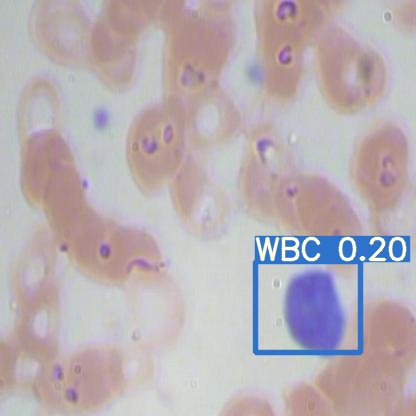

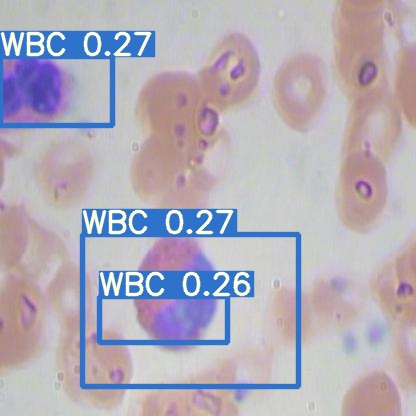

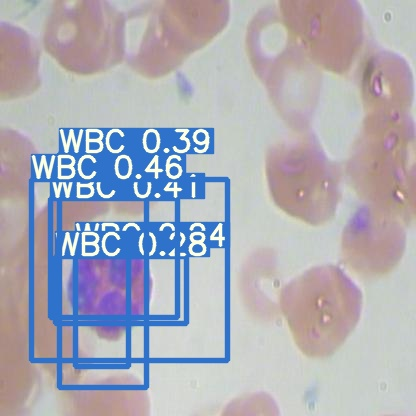

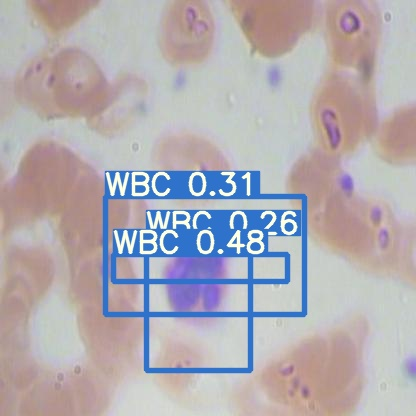

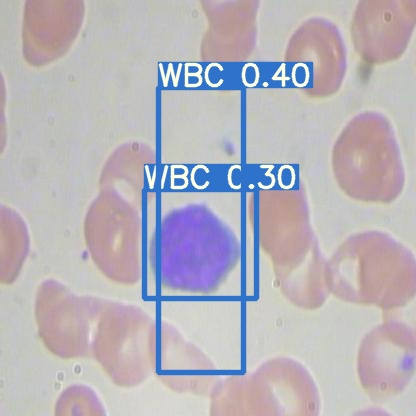

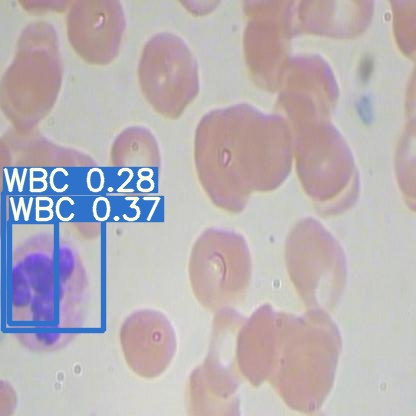

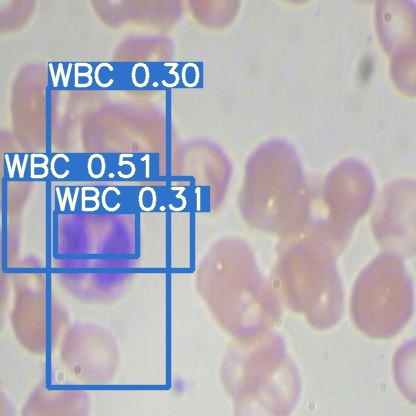

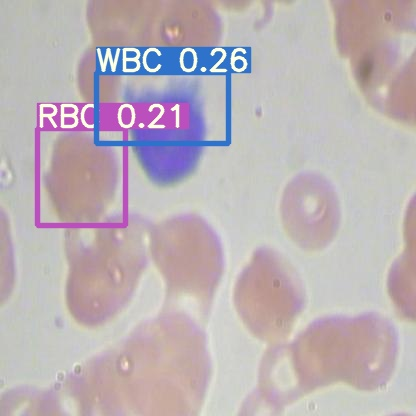

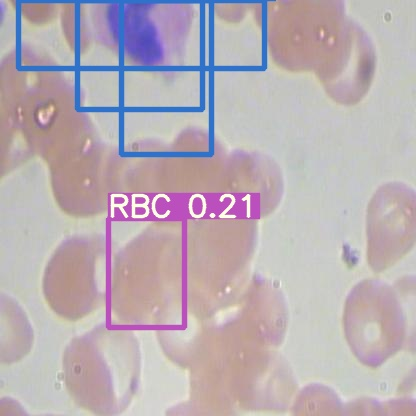

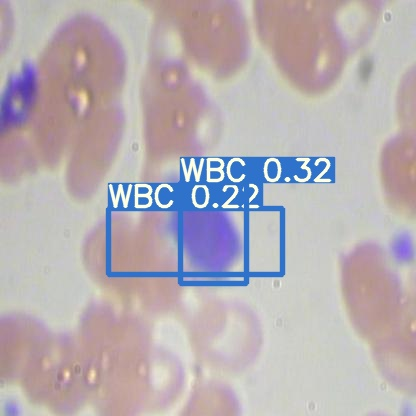

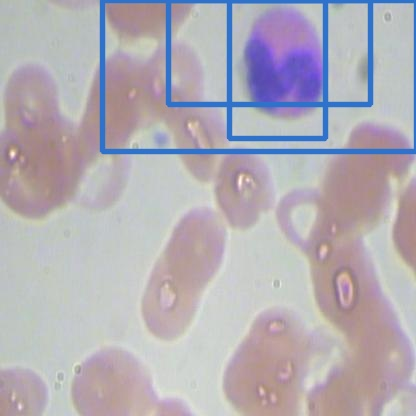

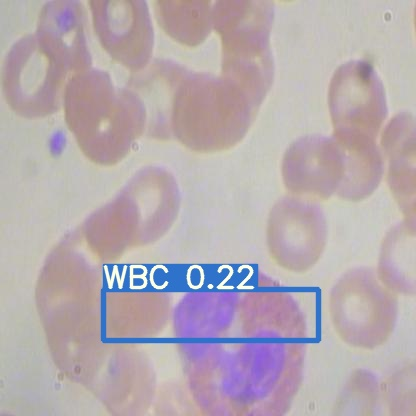

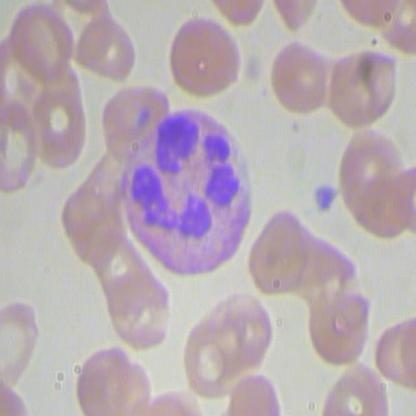

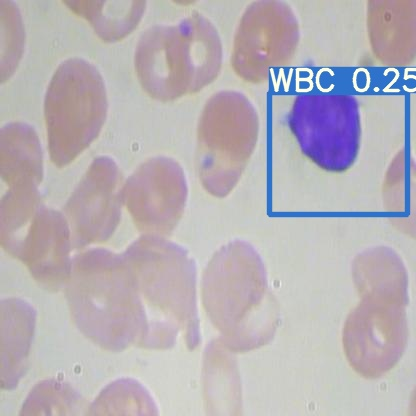

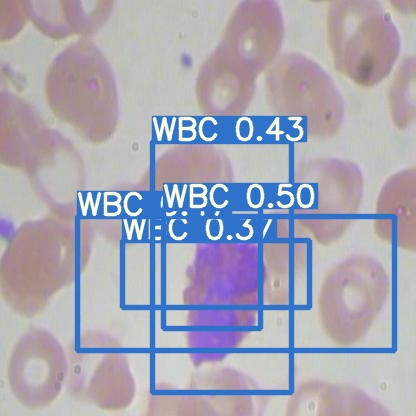

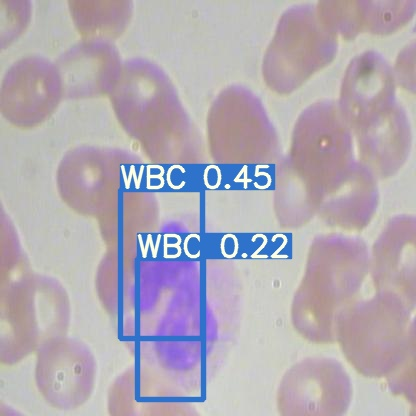

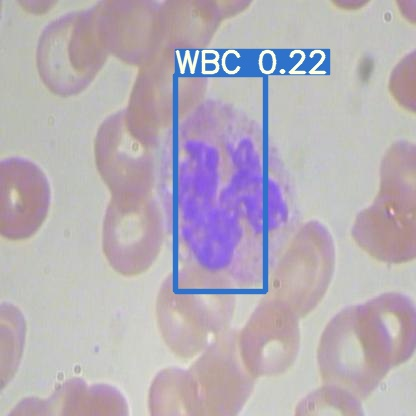

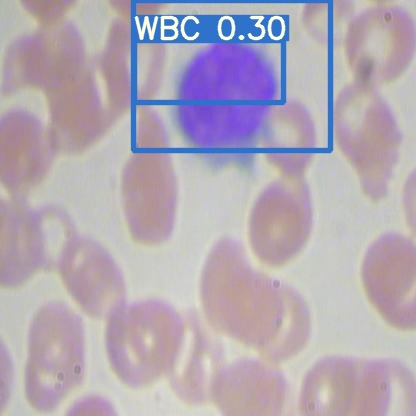

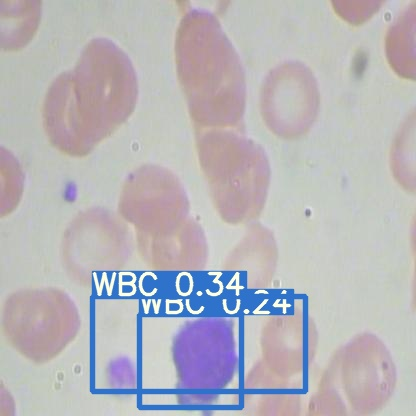

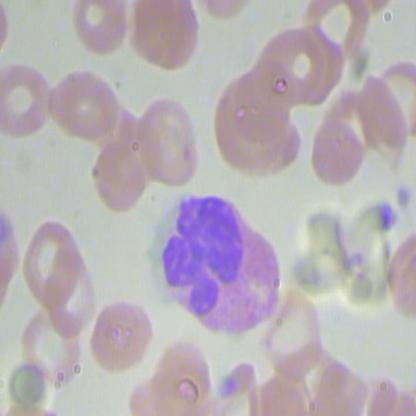

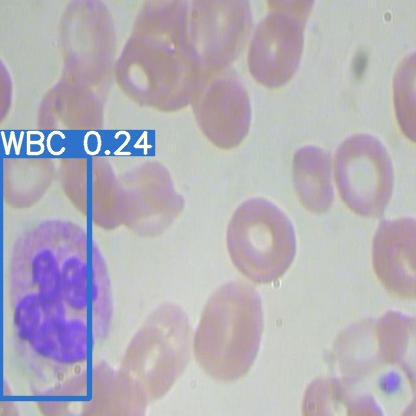

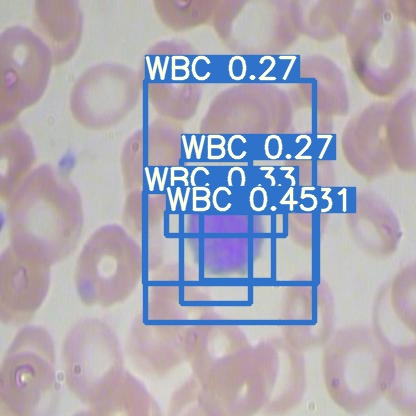

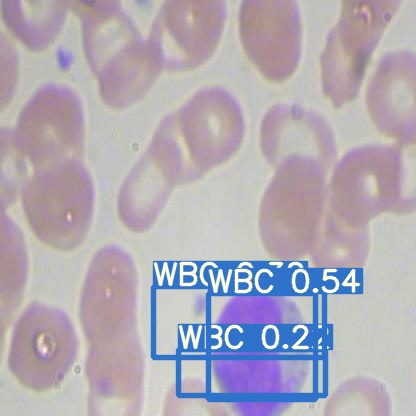

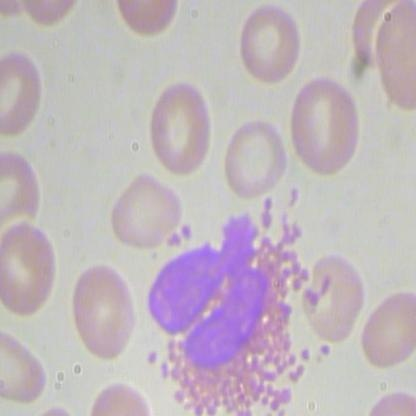

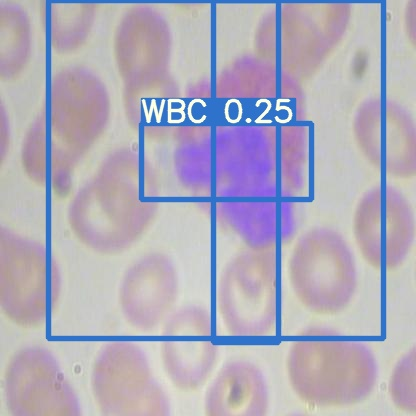

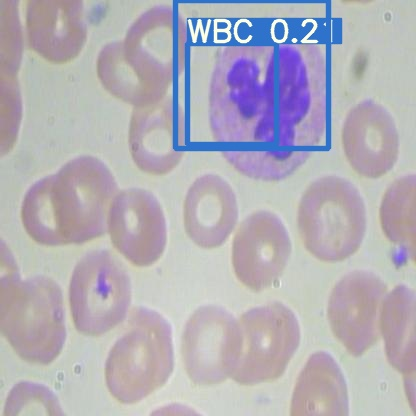

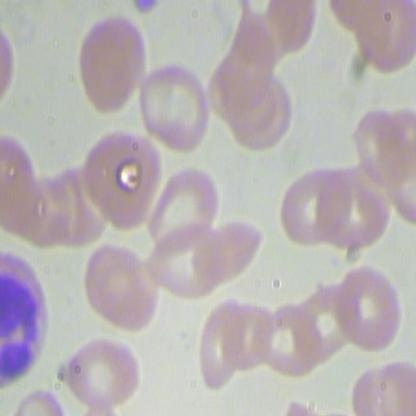

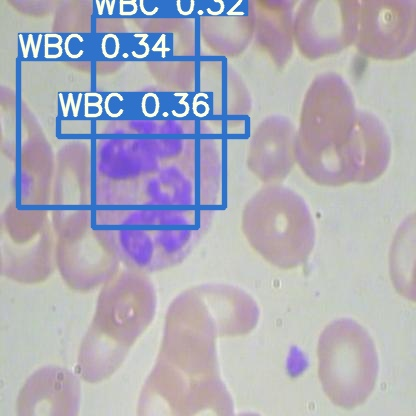

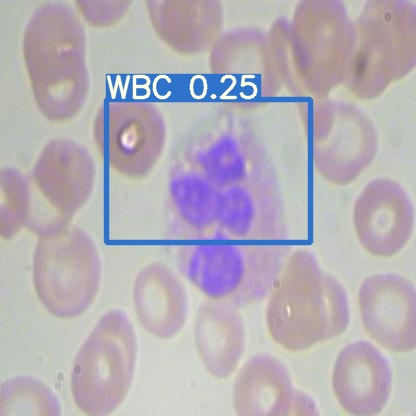

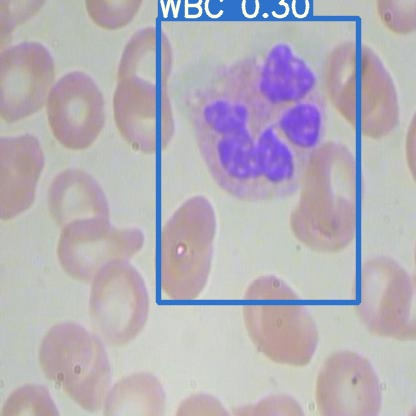

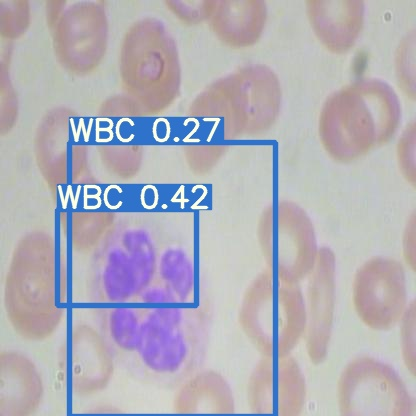

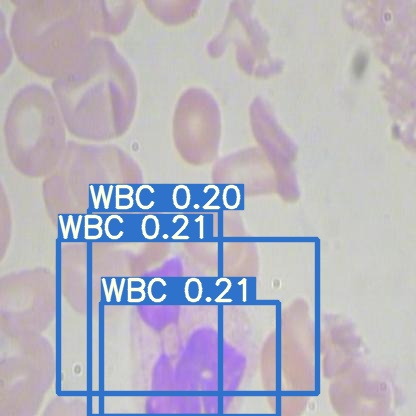

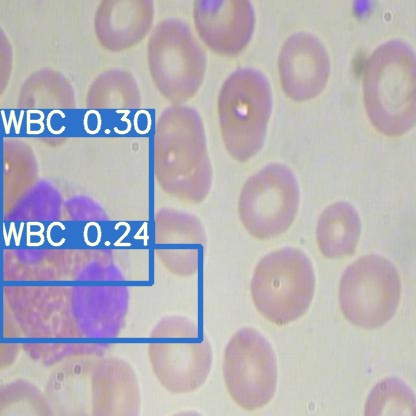

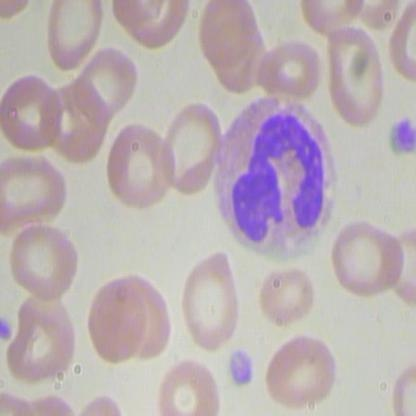

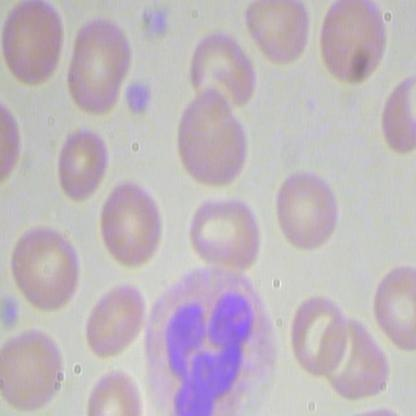

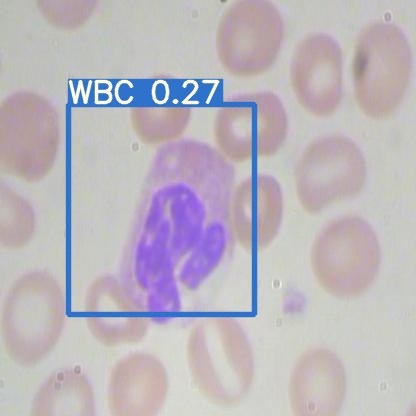

In [26]:
#display inference on ALL test images
#this looks much better with longer training aboveimport glob
from IPython.display import Image, display

for imageName in glob.glob('c:\\Users\\phill\\Documents\\Studies and Research\\Deep learning projects\\Object detection and tracking\\yolov5\\runs\\detect\\exp3\\*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")